In [ ]:
# Install necessary libraries if not already installed
!pip install pandas matplotlib seaborn scikit-learn shap lime graphviz imbalanced-learn

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import shap
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

import warnings

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=d130bf6ff932725b86aa7a2e956a0e59b4f9e0f3b88c511bca9fecc733f06204
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install necessary libraries if not already installed
!pip install pandas matplotlib seaborn scikit-learn shap lime graphviz imbalanced-learn

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import shap
from lime.lime_tabular import LimeTabularExplainer # This line requires the 'lime' package
import matplotlib.pyplot as plt
import seaborn as sns # Make sure to import this if you are using sns

# Load and preprocess data
df = pd.read_csv("/content/drive/MyDrive/Diabetics Dataset/processed_diabetes_data.csv")  # Replace with your dataset path

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Check the column names to ensure 'Label' exists
print("Columns in the dataset:", df.columns)

# Ensure 'Label' is available as the target variable
if 'Label' in df.columns:
    X = df.drop(columns=['Label'])  # Features
    y = df['Label']  # Target variable (Label for classification)
else:
    print("Error: 'Label' column not found in the dataset.")
    exit()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (Reduce test size for faster testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Columns in the dataset: Index(['Label', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')


In [ ]:
# 1. Bagging - RandomForestClassifier (Reduce n_estimators to speed up)
rf_model = RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)  # n_estimators=20 for faster processing
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# 2. Boosting - GradientBoostingClassifier (No parallelism)
gb_model = GradientBoostingClassifier(n_estimators=20, random_state=42)  # Reduced n_estimators to 20
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# 3. AdaBoost - Adding AdaBoostClassifier
ada_model = AdaBoostClassifier(n_estimators=20, random_state=42)  # Reduced n_estimators to speed up
ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.predict(X_test)

# 4. Stacking - Using Logistic Regression as meta-model and simpler base models
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)),  # Reduced n_estimators
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=20, random_state=42))  # Adding AdaBoost as a base learner
]
meta_learner = LogisticRegression()
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

In [ ]:
# 5. Voting - Hard and Soft Voting Classifier (Reduced n_estimators)
hard_voting_model = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)),
    ('gb', GradientBoostingClassifier(n_estimators=20, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=20, random_state=42))  # Adding AdaBoost to the VotingClassifier
], voting='hard')

soft_voting_model = VotingClassifier(estimators=[
    ('rf', RandomForestClassifier(n_estimators=20, random_state=42, n_jobs=-1)),
    ('gb', GradientBoostingClassifier(n_estimators=20, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('ada', AdaBoostClassifier(n_estimators=20, random_state=42))  # Adding AdaBoost to the VotingClassifier
], voting='soft')

hard_voting_model.fit(X_train, y_train)
soft_voting_model.fit(X_train, y_train)
y_pred_hard = hard_voting_model.predict(X_test)
y_pred_soft = soft_voting_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:
# 6. Function to evaluate model performance and return metrics
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)  # Add AUC evaluation
    conf_matrix = confusion_matrix(y_true, y_pred)  # Confusion matrix
    return accuracy, precision, recall, f1, auc, conf_matrix

# Create an empty list to store performance metrics
performance_metrics = []

# Evaluate each model and generate confusion matrix figures
models = {
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model,
    "Stacking Classifier": stacking_model,
    "Hard Voting": hard_voting_model,
    "Soft Voting": soft_voting_model,
    "AdaBoost": ada_model
}

# Predicting and evaluating each model
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")

    # Get predictions from each model
    if model_name in ["Hard Voting", "Soft Voting"]:
        y_pred = model.predict(X_test)  # For voting classifiers, we use predict()
    else:
        y_pred = model.predict(X_test)

    # Evaluate performance
    accuracy, precision, recall, f1, auc, conf_matrix = evaluate_model(y_test, y_pred)

    # Append performance metrics to the list
    performance_metrics.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC-AUC": auc
    })

    # Print Confusion Matrix
    print(f"Confusion Matrix for {model_name}:")
    print(conf_matrix)

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Save the confusion matrix plot
    plt.savefig(f"{model_name}_confusion_matrix.png")
    plt.close()

# Create a DataFrame for performance summary
performance_df = pd.DataFrame(performance_metrics)

# Print the performance summary table
print("\nPerformance Summary Table:")
print(performance_df)

# Optionally, you can save this table to a CSV file
performance_df.to_csv("model_performance_summary.csv", index=False)



Evaluating Random Forest...
Confusion Matrix for Random Forest:
[[42231  1508]
 [ 5774  1223]]

Evaluating Gradient Boosting...
Confusion Matrix for Gradient Boosting:
[[43433   306]
 [ 6519   478]]

Evaluating Stacking Classifier...
Confusion Matrix for Stacking Classifier:
[[42993   746]
 [ 6029   968]]

Evaluating Hard Voting...
Confusion Matrix for Hard Voting:
[[43283   456]
 [ 6342   655]]

Evaluating Soft Voting...
Confusion Matrix for Soft Voting:
[[41060  2679]
 [ 5190  1807]]

Evaluating AdaBoost...
Confusion Matrix for AdaBoost:
[[42462  1277]
 [ 5608  1389]]

Performance Summary Table:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0        Random Forest  0.856473   0.447821  0.174789  0.251439  0.570156
1    Gradient Boosting  0.865480   0.609694  0.068315  0.122863  0.530659
2  Stacking Classifier  0.866466   0.564761  0.138345  0.222248  0.560645
3          Hard Voting  0.866012   0.589559  0.093612  0.161569  0.541593
4          Soft Voting  

In [ ]:
# 7. Cross-Validation Evaluation (Reduce number of folds to speed up)
from sklearn.model_selection import cross_val_score

def cross_val_scores(model, X, y):
    scores = cross_val_score(model, X, y, cv=2, scoring='accuracy', n_jobs=-1)  # Reduced cv to 2 folds
    print(f"Cross-validation scores: {scores}")
    print(f"Mean CV score: {scores.mean()}")

# Evaluate cross-validation scores for each model
print("\nRandom Forest Cross-validation:")
cross_val_scores(rf_model, X_scaled, y)

print("\nGradient Boosting Cross-validation:")
cross_val_scores(gb_model, X_scaled, y)

print("\nAdaBoost Cross-validation:")
cross_val_scores(ada_model, X_scaled, y)

print("\nStacking Classifier Cross-validation:")
cross_val_scores(stacking_model, X_scaled, y)

print("\nHard Voting Cross-validation:")
cross_val_scores(hard_voting_model, X_scaled, y)

print("\nSoft Voting Cross-validation:")
cross_val_scores(soft_voting_model, X_scaled, y)


Random Forest Cross-validation:
Cross-validation scores: [0.85730842 0.85670924]
Mean CV score: 0.8570088300220751

Gradient Boosting Cross-validation:
Cross-validation scores: [0.86464838 0.8641438 ]
Mean CV score: 0.8643960895616525

AdaBoost Cross-validation:
Cross-validation scores: [0.86392305 0.86386787]
Mean CV score: 0.86389545884579

Stacking Classifier Cross-validation:
Cross-validation scores: [0.86437244 0.86454588]
Mean CV score: 0.8644591611479029

Hard Voting Cross-validation:
Cross-validation scores: [0.86492431 0.86463261]
Mean CV score: 0.8647784610532955

Soft Voting Cross-validation:
Cross-validation scores: [0.84463892 0.84362189]
Mean CV score: 0.8441304005045727


SHAP Analysis for Random Forest...


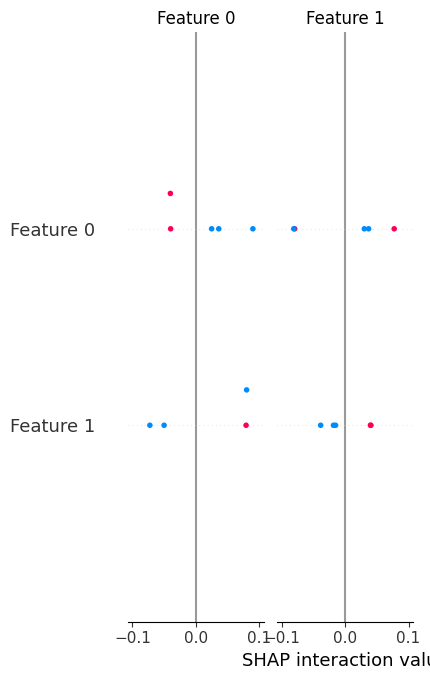

SHAP Analysis for Gradient Boosting...


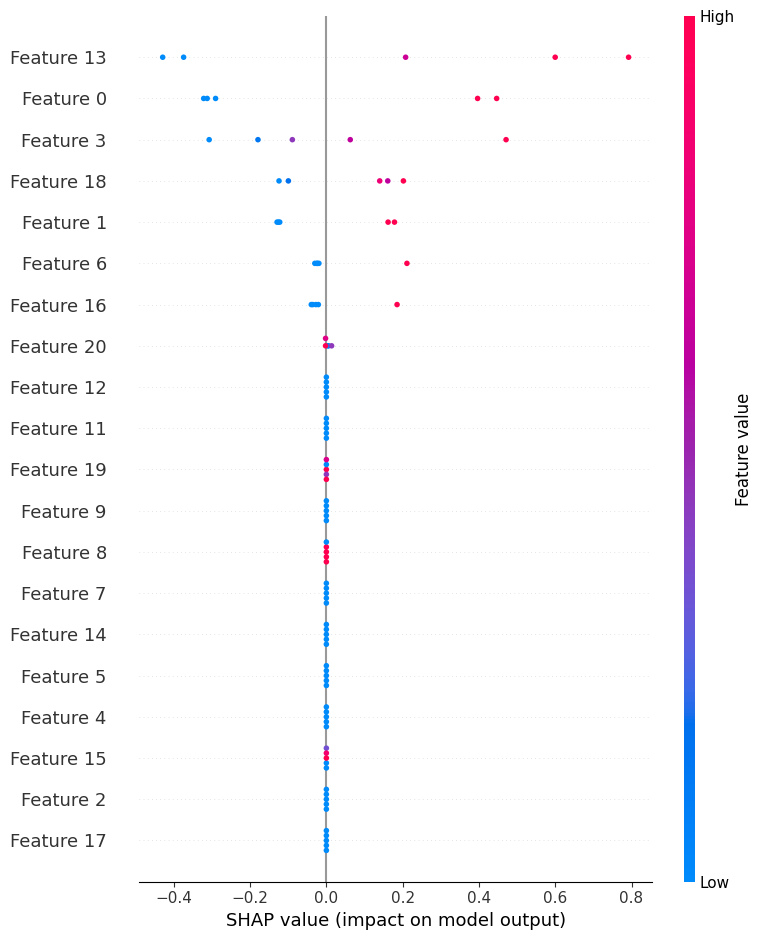

SHAP Analysis for AdaBoost...


  0%|          | 0/10 [00:00<?, ?it/s]

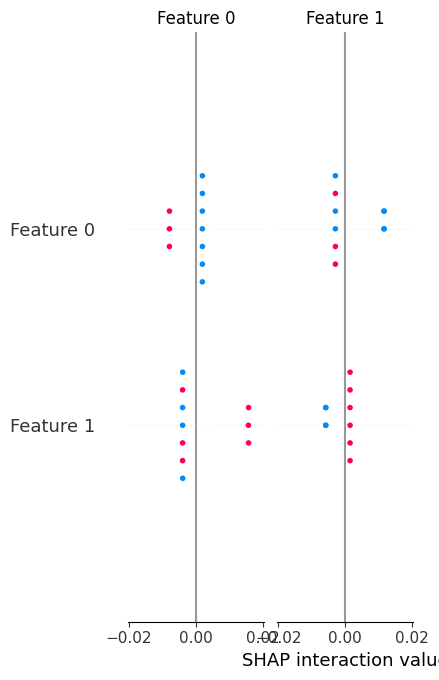

In [ ]:
# 8. Explainable AI (SHAP)
import shap

# SHAP Analysis for RandomForest and GradientBoosting
for model, model_name in zip([rf_model, gb_model], ["Random Forest", "Gradient Boosting"]):
    print(f"SHAP Analysis for {model_name}...")
    explainer = shap.TreeExplainer(model)
    background_data = shap.sample(X_train, 5)  # Reduce the background sample size to 100
    shap_values = explainer.shap_values(background_data)
    shap.summary_plot(shap_values, background_data)

# AdaBoost SHAP Analysis using KernelExplainer
print(f"SHAP Analysis for AdaBoost...")

# Use a smaller background dataset for KernelExplainer
background_data = X_train[:5]  # Reduce to 100 samples
explainer = shap.KernelExplainer(ada_model.predict_proba, background_data)

# Select a subset of samples to explain
sample_data = X_test[:10]  # Explain 10 instances
shap_values = explainer.shap_values(sample_data)

# Plot SHAP summary
shap.summary_plot(shap_values, sample_data)

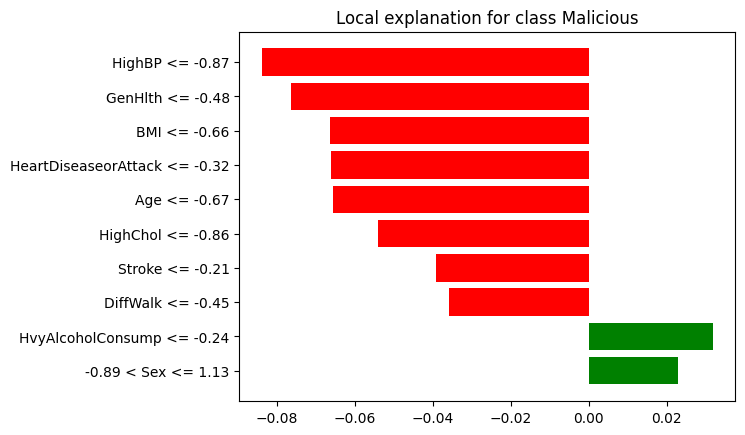

In [ ]:
# 9. LIME (Local Interpretable Model-agnostic Explanations)
explainer_lime = LimeTabularExplainer(
    X_train,
    training_labels=y_train.values,
    feature_names=X.columns,
    class_names=['Benign', 'Malicious'],
    discretize_continuous=True
)

# Explain a prediction for a specific instance
i = 2  # Choose an index from the test set to explain
exp = explainer_lime.explain_instance(X_test[i], rf_model.predict_proba)

# Display LIME explanation
exp.show_in_notebook()

# Save the explanation to an HTML file for further review
exp.save_to_file('lime_explanation.html')

# Example of displaying the explanation in a plot format
exp.as_pyplot_figure()
plt.show()

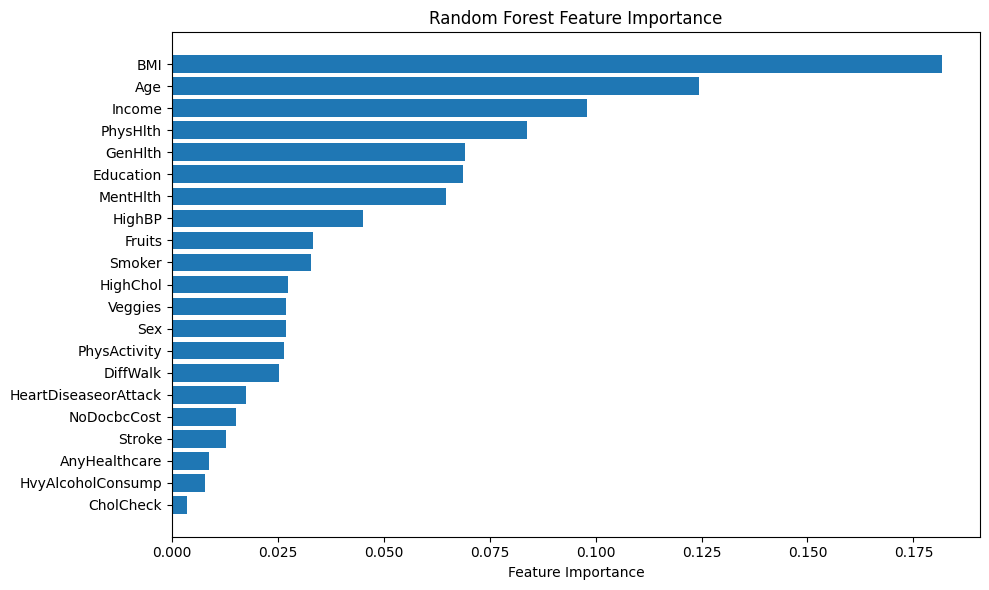

In [ ]:
# 10. Feature Importance Visualization
# Random Forest Feature Importance
plt.figure(figsize=(10, 6))
features = X.columns
importances = rf_model.feature_importances_
indices = importances.argsort()

# Plot the feature importances
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.savefig("rf_feature_importance.png")
plt.show()

<Figure size 1000x600 with 0 Axes>

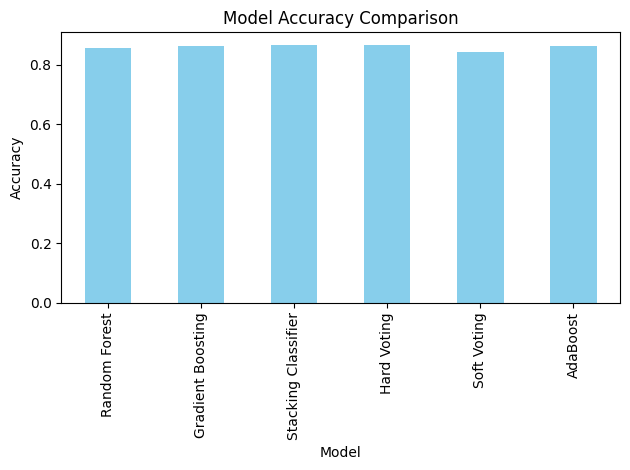

<Figure size 1000x600 with 0 Axes>

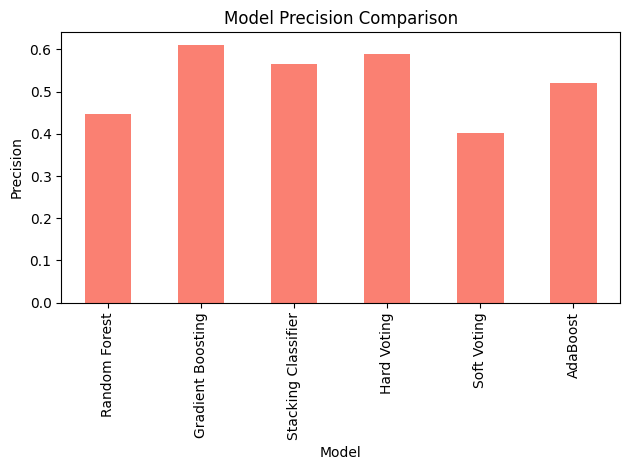

<Figure size 1000x600 with 0 Axes>

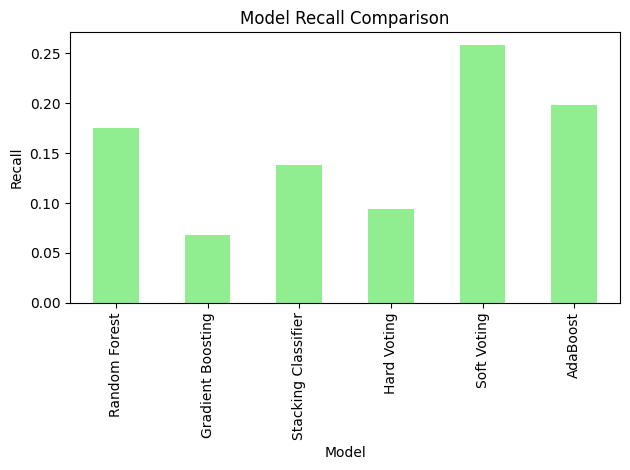

<Figure size 1000x600 with 0 Axes>

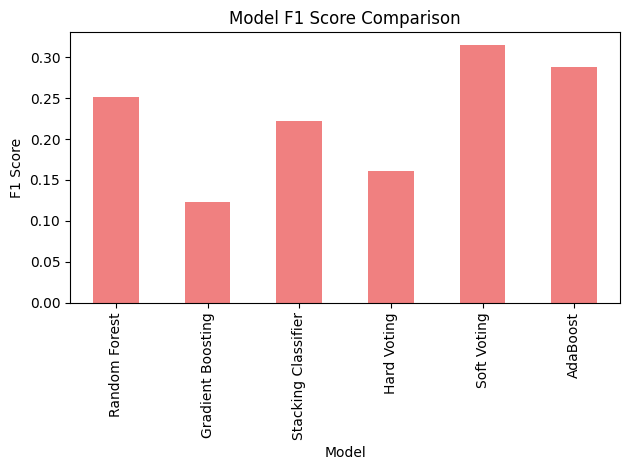

<Figure size 1000x600 with 0 Axes>

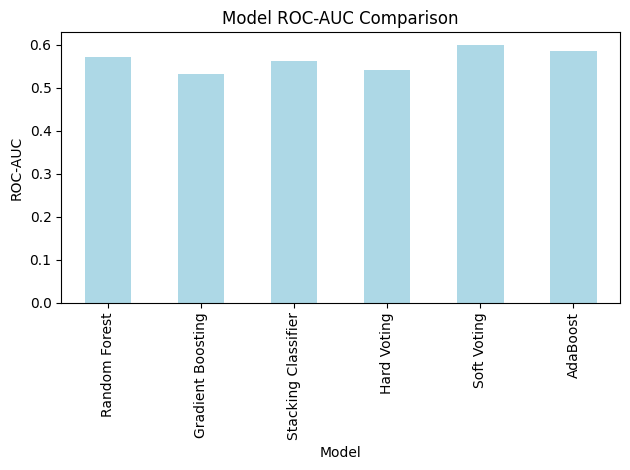

In [ ]:
# 11. Model Comparison - Performance Visualization
# Create bar charts to compare model performance metrics

# Accuracy Comparison
plt.figure(figsize=(10, 6))
performance_df.set_index('Model').plot(kind='bar', y='Accuracy', legend=False, color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.tight_layout()
plt.savefig("model_accuracy_comparison.png")
plt.show()

# Precision Comparison
plt.figure(figsize=(10, 6))
performance_df.set_index('Model').plot(kind='bar', y='Precision', legend=False, color='salmon')
plt.title('Model Precision Comparison')
plt.ylabel('Precision')
plt.xlabel('Model')
plt.tight_layout()
plt.savefig("model_precision_comparison.png")
plt.show()

# Recall Comparison
plt.figure(figsize=(10, 6))
performance_df.set_index('Model').plot(kind='bar', y='Recall', legend=False, color='lightgreen')
plt.title('Model Recall Comparison')
plt.ylabel('Recall')
plt.xlabel('Model')
plt.tight_layout()
plt.savefig("model_recall_comparison.png")
plt.show()

# F1 Score Comparison
plt.figure(figsize=(10, 6))
performance_df.set_index('Model').plot(kind='bar', y='F1 Score', legend=False, color='lightcoral')
plt.title('Model F1 Score Comparison')
plt.ylabel('F1 Score')
plt.xlabel('Model')
plt.tight_layout()
plt.savefig("model_f1_score_comparison.png")
plt.show()

# ROC-AUC Comparison
plt.figure(figsize=(10, 6))
performance_df.set_index('Model').plot(kind='bar', y='ROC-AUC', legend=False, color='lightblue')
plt.title('Model ROC-AUC Comparison')
plt.ylabel('ROC-AUC')
plt.xlabel('Model')
plt.tight_layout()
plt.savefig("model_roc_auc_comparison.png")
plt.show()

In [ ]:
# 12. Saving the final models
# Save the trained models using joblib for future use
import joblib

# Save each model
joblib.dump(rf_model, 'random_forest_model.pkl')
joblib.dump(gb_model, 'gradient_boosting_model.pkl')
joblib.dump(ada_model, 'adaboost_model.pkl')
joblib.dump(stacking_model, 'stacking_model.pkl')
joblib.dump(hard_voting_model, 'hard_voting_model.pkl')
joblib.dump(soft_voting_model, 'soft_voting_model.pkl')

print("Models saved successfully!")

Models saved successfully!


In [ ]:
# 13. Conclusion and Next Steps
print("\nModel evaluation and analysis are complete. Here's a summary of what was done:")
print("- Multiple machine learning models were evaluated: Random Forest, Gradient Boosting, AdaBoost, Stacking, and Voting classifiers.")
print("- Model performance metrics were calculated: Accuracy, Precision, Recall, F1 Score, ROC-AUC.")
print("- Confusion matrices were plotted for each model.")
print("- SHAP and LIME were used for model explainability and interpretability.")
print("- Model comparison visualizations (Accuracy, Precision, Recall, F1 Score, ROC-AUC) were generated.")
print("- The best-performing models were saved for future use.")


Model evaluation and analysis are complete. Here's a summary of what was done:
- Multiple machine learning models were evaluated: Random Forest, Gradient Boosting, AdaBoost, Stacking, and Voting classifiers.
- Model performance metrics were calculated: Accuracy, Precision, Recall, F1 Score, ROC-AUC.
- Confusion matrices were plotted for each model.
- SHAP and LIME were used for model explainability and interpretability.
- Model comparison visualizations (Accuracy, Precision, Recall, F1 Score, ROC-AUC) were generated.
- The best-performing models were saved for future use.


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

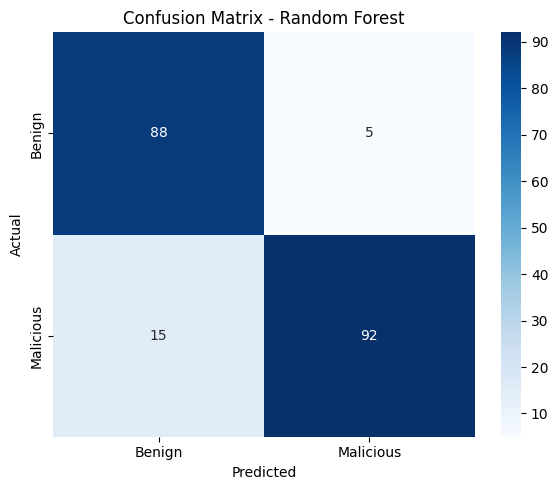

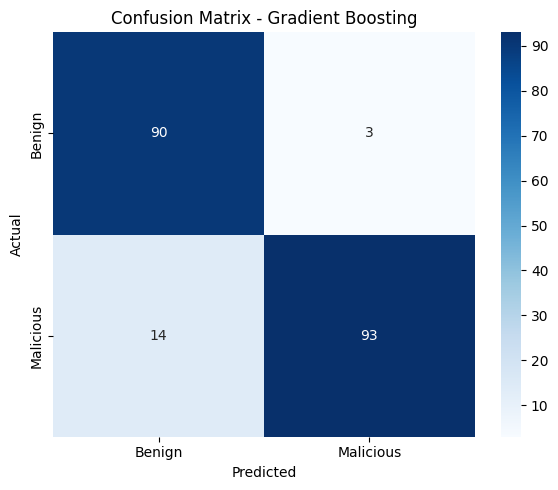

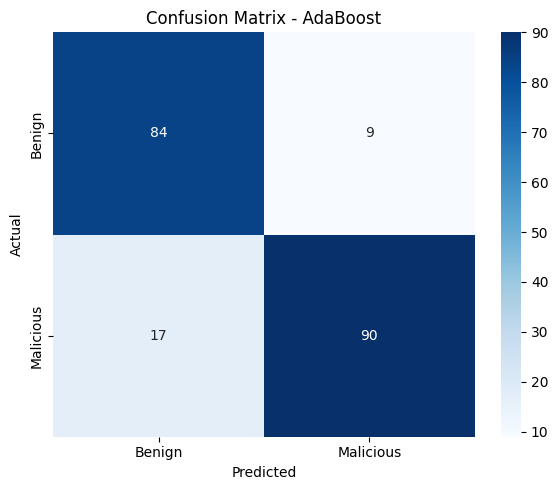

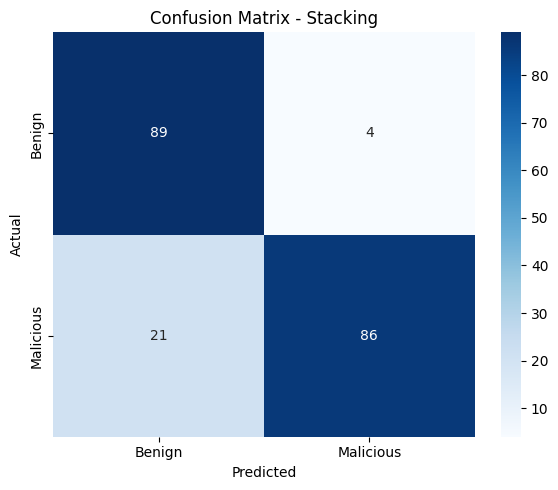

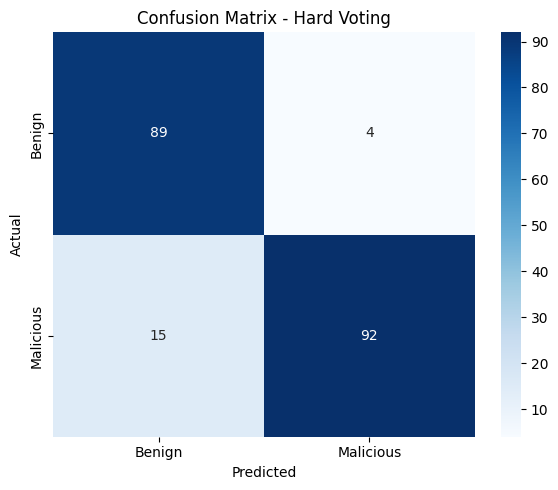

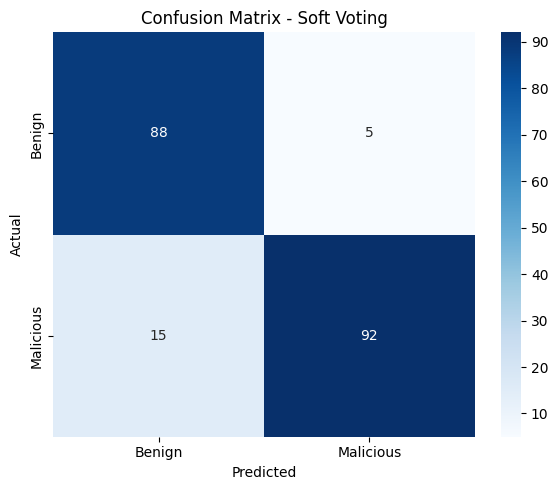

Confusion matrices for all models have been saved as images.


In [ ]:
# 14. Import necessary libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.datasets import make_classification

# Generate a sample dataset for demonstration
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
ada_model = AdaBoostClassifier(random_state=42)

# Define Stacking and Voting Classifiers
estimators = [('rf', rf_model), ('gb', gb_model), ('ada', ada_model)]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier())
hard_voting_model = VotingClassifier(estimators=estimators, voting='hard')
soft_voting_model = VotingClassifier(estimators=estimators, voting='soft')

# Train the models
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
ada_model.fit(X_train, y_train)
stacking_model.fit(X_train, y_train)
hard_voting_model.fit(X_train, y_train)
soft_voting_model.fit(X_train, y_train)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()

# Generate and plot confusion matrices
models = {
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'AdaBoost': ada_model,
    'Stacking': stacking_model,
    'Hard Voting': hard_voting_model,
    'Soft Voting': soft_voting_model
}

for model_name, model in models.items():
    cm = confusion_matrix(y_test, model.predict(X_test))
    plot_confusion_matrix(cm, model_name)

print("Confusion matrices for all models have been saved as images.")